In [369]:
import convolution.kernel
import convolution.matrix
from noise import guassian_noise

from signals import rectangle
from domain import equispaced_points
from deconvolution.varpro import variable_projection


import matplotlib.pyplot as plt

from scipy.sparse import spdiags


import numpy as np

Grid of equally spaced points.

In [370]:
t = equispaced_points(512)

Construct latent signal.

In [371]:
latent_signal = rectangle(t)

Construct two gaussian kernels for kernel mixture. 

In [372]:
k1_true = convolution.kernel.Gaussian(
    domain=t, 
    standard_deviation=30
)
k2_true = convolution.kernel.Gaussian(
    domain=t, 
    standard_deviation=15
)

Construct the convolution operator using a mixture of gaussian kernels. 

In [373]:
K_true = convolution.matrix.Operator(
    kernel=convolution.kernel.Mixture(
        weights=[0.4,0.6],
        kernels=[k1_true, k2_true]
    ), 
    structure=convolution.matrix.toeplitz
)

Convolute the latent signal with the convolution operator. 

In [374]:
convoluted_signal = K_true.image @ latent_signal

Set percentage of noise to add to the convoluted signal. 

In [375]:
percentage = 0.02

Construct gaussian noise. 

In [376]:
noise = guassian_noise(percentage, convoluted_signal)

Add the noise to the convoluted signal. 

In [377]:
data = convoluted_signal + noise

Construct the initial guess of the kernel mixture. 

In [378]:
k1 = convolution.kernel.Gaussian(
    domain=t, 
    standard_deviation=60
)
k2 = convolution.kernel.Gaussian(
    domain=t, 
    standard_deviation=20
)
K_guess = convolution.matrix.Operator(
    kernel=convolution.kernel.Mixture(
        weights=[0.5, 0.5], 
        kernels=[k1, k2]
    ), 
    structure=convolution.matrix.toeplitz
)

Define regulation matrices. 

The identity matrix. 

In [379]:
def L(x): 
    return np.identity(x.size)

Total variation.

In [380]:
def total_variation(x): 
    BETA = 1e-16
    D = forward_difference_matrix(x)
    return np.diag((1/(((D @ x)**2 + BETA**2)**(1/4)))) @ D

def forward_difference_matrix(data): 
    return spdiags([-np.ones_like(data), np.ones_like(data)], [0, 1], data.size, data.size).toarray()

Define the an approximation to the jacobian matrix. 

In [381]:
def rjf_jacobian(K, x): 
    return np.transpose(np.array(K.partial_derivatives) @ x)

Set the regularization parameter. 

In [412]:
regularization_parameter = 1e-1

Run the variable projection method using the initial guess, `rjf_jacobian`, and regulation using total variation. Also print summary. 

In [413]:
K, x, iterations, change, history = variable_projection(
    data, 
    K_guess, 
    rjf_jacobian,
    regularization_parameter=regularization_parameter, 
    regularization_matrix=total_variation, 
    maximum_iterations=1000,
    signal_guess=None,
    change=1e-16
)
MSE_kernel_guess = np.linalg.norm(K_true.kernel.image - K_guess.kernel.image)**2 / data.size 
MSE_kernel_result = np.linalg.norm(K_true.kernel.image - K.kernel.image)**2 / data.size 
MSE_signal_data = np.linalg.norm(latent_signal - data)**2 / data.size 
MSE_signal_result = np.linalg.norm(latent_signal - x)**2 / data.size 
max_kernel_guess_error = np.linalg.norm(K_true.kernel.image - K_guess.kernel.image, np.inf)
max_kernel_result_error = np.linalg.norm(K_true.kernel.image - K.kernel.image, np.inf)
max_signal_data_error = np.linalg.norm(latent_signal - data, np.inf)
max_signal_result_error = np.linalg.norm(latent_signal - x, np.inf)
print(f'AFTER {iterations} iterations\n\n')
print(f'STOPED when MSE of change in kernel estimate is {change:1.3e}\n\n')
print(f'Regulization parameter: {regularization_parameter}\n\n')
print(f'Variables (TRUE): {K_true.kernel.variables}')
print(f'Variables (GUESS): {K_guess.kernel.variables}')
print(f'Variables (RESULT): {K.kernel.variables}\n\n')
print(f'Mean Squared Error of Kernel (TRUE & GUESS): {MSE_kernel_guess:1.3e}')
print(f'Mean Squared Error of Kernel (TRUE & RESULT): {MSE_kernel_result:1.3e}\n')
print(f'Max error of Kernel (TRUE & GUESS): {max_kernel_guess_error:1.3e}')
print(f'Max error of Kernel (TRUE & RESULT): {max_kernel_result_error:1.3e}\n\n')
print(f'Mean Squared Error of Signal (TRUE & DATA): {MSE_signal_data:1.3e}')
print(f'Mean Squared Error of Signal (TRUE & RESULT): {MSE_signal_result:1.3e}\n')
print(f'Max error of Signal (TRUE & DATA): {max_signal_data_error:1.3e}')
print(f'Max error of Signal (TRUE & RESULT): {max_signal_result_error:1.3e}')


AFTER 1000 iterations


STOPED when MSE of change in kernel estimate is 1.369e-15


Regulization parameter: 0.1


Variables (TRUE): (0.4, 0.6, 30, 15)
Variables (GUESS): (0.5, 0.5, 60, 20)
Variables (RESULT): (0.43665484135535026, 0.5633451586446497, 27.978197665190496, 14.35668897618345)


Mean Squared Error of Kernel (TRUE & GUESS): 3.099e-06
Mean Squared Error of Kernel (TRUE & RESULT): 1.293e-08

Max error of Kernel (TRUE & GUESS): 7.979e-03
Max error of Kernel (TRUE & RESULT): 6.035e-04


Mean Squared Error of Signal (TRUE & DATA): 1.787e-02
Mean Squared Error of Signal (TRUE & RESULT): 1.663e-03

Max error of Signal (TRUE & DATA): 4.857e-01
Max error of Signal (TRUE & RESULT): 5.584e-01


Visualize the results.

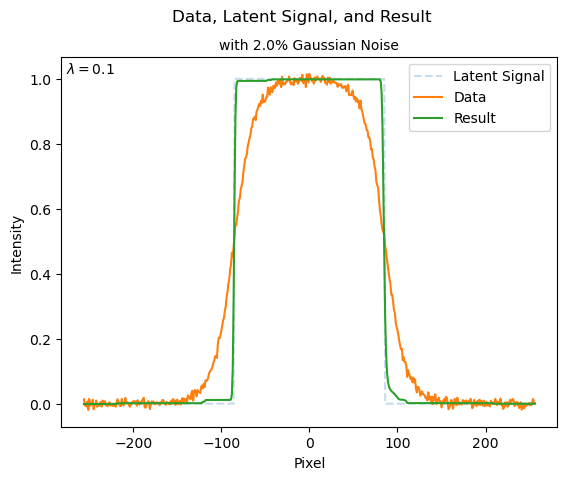

In [414]:
fig, ax = plt.subplots()
plt.suptitle('Data, Latent Signal, and Result')
plt.title(f'with {percentage * 100:}% Gaussian Noise', fontsize=10)
ax.plot(t, latent_signal, '--', label='Latent Signal', alpha=0.25)
ax.plot(t, data, label='Data')
ax.plot(t, x, label='Result')
ax.legend()
ax.text(.01, .99, r'$\lambda = $' + f'{regularization_parameter}', ha='left', va='top', transform=ax.transAxes)
plt.xlabel('Pixel')
plt.ylabel('Intensity');

Mixture weights and components of the resulting kernel mixture. 

In [415]:
w1, w2 = K.kernel.weights
k1, k2 = K.kernel.components

Visualize the kernel result.

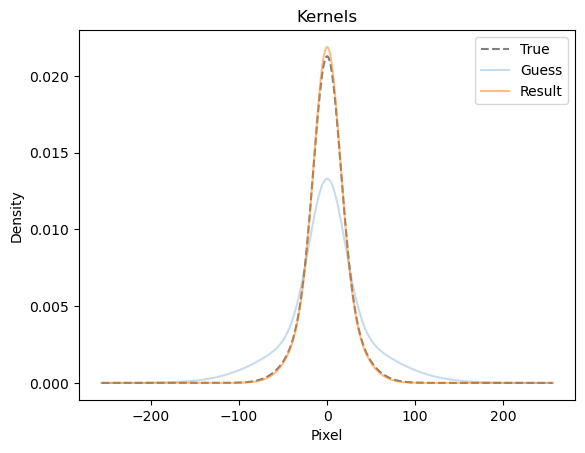

In [416]:
plt.title("Kernels")
plt.plot(t, K_true.kernel.image, 'k--', label='True', alpha=0.5)
plt.plot(t, K_guess.kernel.image, label="Guess", alpha=0.25)
plt.plot(t, K.kernel.image, label='Result', alpha=0.5)
plt.legend()
plt.xlabel('Pixel')
plt.ylabel('Density');

Get errors per iteration for convergence results. 

Error of kernel.

In [417]:
err_kernel = [np.linalg.norm(K.kernel.image - K_true.kernel.image) for K, _, _, _ in history]

Error of signal. 

In [418]:
err_x = [np.linalg.norm(latent_signal - x) for _, x, _, _ in history]

The change in the stopping condition per iteration.

In [419]:
mean_squared_err = [err for _, _, _, err in history]

Get the objective function. 

In [420]:
functional_per_iteration = [np.linalg.norm(K.image @ x - data)**2 + regularization_parameter**2 * np.linalg.norm(L(x) * x)**2 for K, x, _, _ in history ]


In [421]:
best_fit_per_iteration = [np.linalg.norm(K.image @ x - data)**2 for K, x, _, _ in history ]

In [422]:
regularization_parameter_per_iteration = [ regularization_parameter**2 * np.linalg.norm(L(x) * x)**2 for K, x, _, _ in history ]

In [423]:
m = min(best_fit_per_iteration)

Visualize convergence of kernel result.

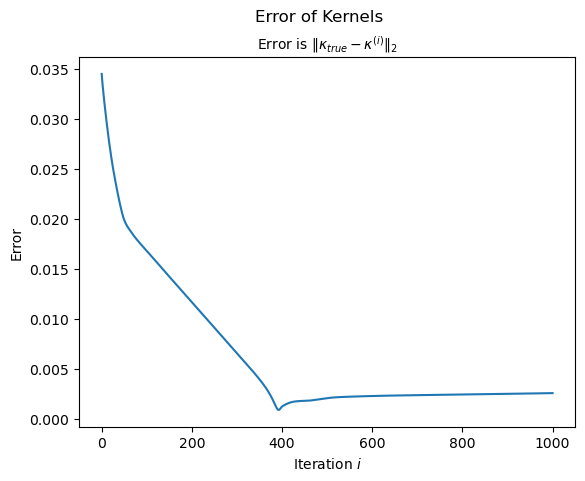

In [424]:
plt.suptitle('Error of Kernels')
plt.title(r'Error is $\|\kappa_{true} - \kappa^{(i)}\|_2$', fontsize=10)
plt.plot(err_kernel)
plt.xlabel(r'Iteration $i$')
plt.ylabel('Error');

Visualize convergence of signal.

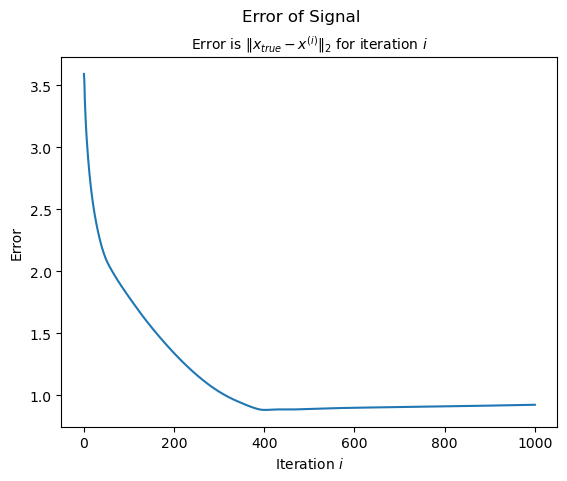

In [425]:
plt.suptitle('Error of Signal')
plt.title(r'Error is $\|x_{true} - x^{(i)} \|_2$ for iteration $i$', fontsize=10)
plt.plot(err_x)
plt.xlabel(r'Iteration $i$')
plt.ylabel('Error');

Visualize the stopping condition per iteration. 

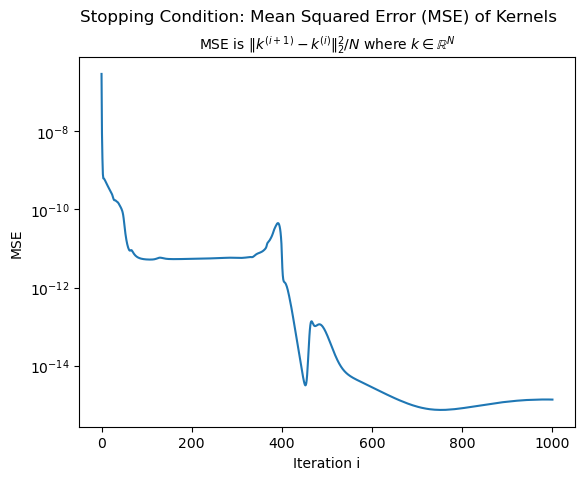

In [426]:
plt.suptitle('Stopping Condition: Mean Squared Error (MSE) of Kernels')
plt.title(r'MSE is $\|k^{(i+1)} - k^{(i)} \|_2^2 / N$ where $k\in\mathbb{R}^N$', fontsize=10 )
plt.semilogy(mean_squared_err)
plt.ylabel('MSE')
plt.xlabel(r'Iteration i');

Visualize the objective function per iteration.

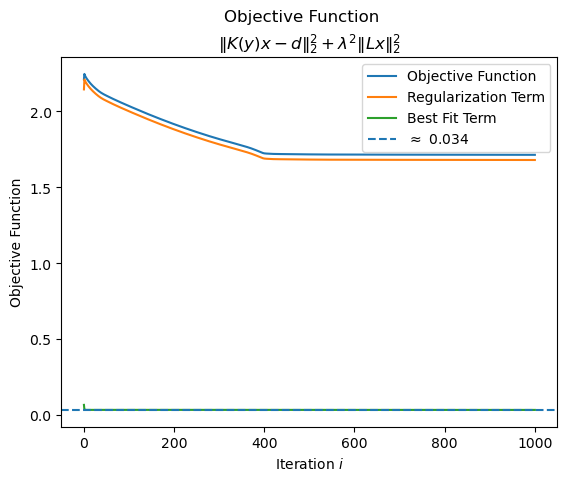

In [427]:
plt.suptitle('Objective Function')
plt.title(r'$\|K(y) x - d\|_2^2 + \lambda^2 \|Lx\|_2^2$')
plt.plot(functional_per_iteration, label='Objective Function')
plt.plot(regularization_parameter_per_iteration, label='Regularization Term')
plt.plot(best_fit_per_iteration, label='Best Fit Term')
plt.axhline(m, linestyle='dashed', label=r'$\approx$ ' + f'{m:.2}')
plt.legend()
plt.xlabel(r'Iteration $i$')
plt.ylabel('Objective Function'); 

Now we try the variable projection method using a different regularization matrix. In this case we use the identity matrix. 

In [428]:
K, x, iterations, change, history = variable_projection(
    data, 
    K_guess, 
    rjf_jacobian,
    regularization_parameter=regularization_parameter, 
    regularization_matrix=L, 
    maximum_iterations=1000,
    signal_guess=None,
    change=1e-16
)
MSE_kernel_guess = np.linalg.norm(K_true.kernel.image - K_guess.kernel.image)**2 / data.size 
MSE_kernel_result = np.linalg.norm(K_true.kernel.image - K.kernel.image)**2 / data.size 
MSE_signal_data = np.linalg.norm(latent_signal - data)**2 / data.size 
MSE_signal_result = np.linalg.norm(latent_signal - x)**2 / data.size 
max_kernel_guess_error = np.linalg.norm(K_true.kernel.image - K_guess.kernel.image, np.inf)
max_kernel_result_error = np.linalg.norm(K_true.kernel.image - K.kernel.image, np.inf)
max_signal_data_error = np.linalg.norm(latent_signal - data, np.inf)
max_signal_result_error = np.linalg.norm(latent_signal - x, np.inf)
print(f'AFTER {iterations} iterations\n\n')
print(f'STOPED when MSE of change in kernel estimate is {change:1.3e}\n\n')
print(f'Regulization parameter: {regularization_parameter}\n\n')
print(f'Variables (TRUE): {K_true.kernel.variables}')
print(f'Variables (GUESS): {K_guess.kernel.variables}')
print(f'Variables (RESULT): {K.kernel.variables}\n\n')
print(f'Mean Squared Error of Kernel (TRUE & GUESS): {MSE_kernel_guess:1.3e}')
print(f'Mean Squared Error of Kernel (TRUE & RESULT): {MSE_kernel_result:1.3e}\n')
print(f'Max error of Kernel (TRUE & GUESS): {max_kernel_guess_error:1.3e}')
print(f'Max error of Kernel (TRUE & RESULT): {max_kernel_result_error:1.3e}\n\n')
print(f'Mean Squared Error of Signal (TRUE & DATA): {MSE_signal_data:1.3e}')
print(f'Mean Squared Error of Signal (TRUE & RESULT): {MSE_signal_result:1.3e}\n')
print(f'Max error of Signal (TRUE & DATA): {max_signal_data_error:1.3e}')
print(f'Max error of Signal (TRUE & RESULT): {max_signal_result_error:1.3e}')


AFTER 1000 iterations


STOPED when MSE of change in kernel estimate is 9.094e-14


Regulization parameter: 0.1


Variables (TRUE): (0.4, 0.6, 30, 15)
Variables (GUESS): (0.5, 0.5, 60, 20)
Variables (RESULT): (0.003757670988617684, 0.9962423290113823, 67.31254401490972, 0.1796212784597358)


Mean Squared Error of Kernel (TRUE & GUESS): 3.099e-06
Mean Squared Error of Kernel (TRUE & RESULT): 1.879e-03

Max error of Kernel (TRUE & GUESS): 7.979e-03
Max error of Kernel (TRUE & RESULT): 9.750e-01


Mean Squared Error of Signal (TRUE & DATA): 1.787e-02
Mean Squared Error of Signal (TRUE & RESULT): 1.811e-02

Max error of Signal (TRUE & DATA): 4.857e-01
Max error of Signal (TRUE & RESULT): 4.869e-01


Visualize the result.

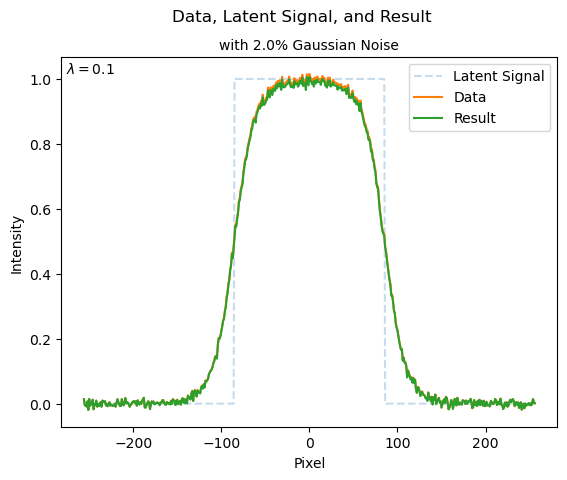

In [429]:
fig, ax = plt.subplots()
plt.suptitle('Data, Latent Signal, and Result')
plt.title(f'with {percentage * 100:}% Gaussian Noise', fontsize=10)
ax.plot(t, latent_signal, '--', label='Latent Signal', alpha=0.25)
ax.plot(t, data, label='Data')
ax.plot(t, x, label='Result')
ax.legend()
ax.text(.01, .99, r'$\lambda = $' + f'{regularization_parameter}', ha='left', va='top', transform=ax.transAxes)
plt.xlabel('Pixel')
plt.ylabel('Intensity');

The result does not approximate the latent signal any better than the provided data. 

Get weights and components of resulting kernel mixture. 

In [430]:
w1, w2 = K.kernel.weights
k1, k2 = K.kernel.components

Visualize resulting kernel mixture. 

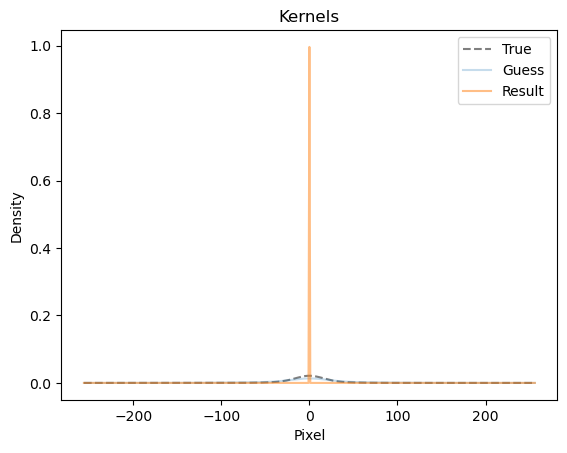

In [431]:
plt.title("Kernels")
plt.plot(t, K_true.kernel.image, 'k--', label='True', alpha=0.5)
plt.plot(t, K_guess.kernel.image, label="Guess", alpha=0.25)
plt.plot(t, K.kernel.image, label='Result', alpha=0.5)
plt.legend()
plt.xlabel('Pixel')
plt.ylabel('Density');

It appears that the variable projection method has returned the dirac delta function. 

In [432]:
functional_per_iteration = [np.linalg.norm(K.image @ x - data)**2 + regularization_parameter**2 * np.linalg.norm(L(x) * x)**2 for K, x, _, _ in history ]

In [433]:
best_fit_per_iteration = [np.linalg.norm(K.image @ x - data)**2 for K, x, _, _ in history ]

In [434]:
regularization_parameter_per_iteration = [ regularization_parameter**2 * np.linalg.norm(L(x) * x)**2 for K, x, _, _ in history ]

In [435]:
m = min(best_fit_per_iteration)


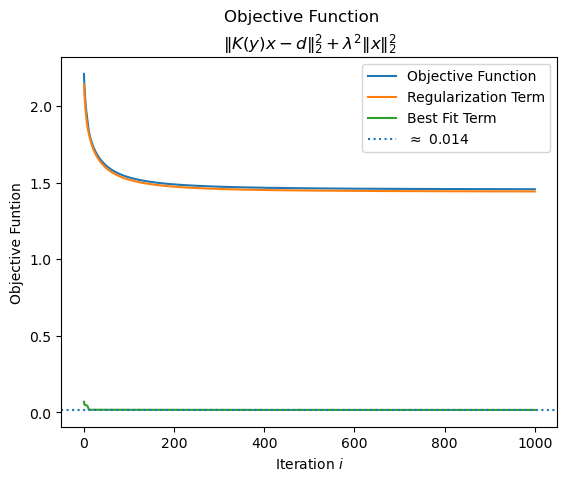

In [436]:
plt.suptitle('Objective Function')
plt.title(r'$\|K(y) x - d\|_2^2 + \lambda^2 \|x\|_2^2$')
plt.plot(functional_per_iteration, label='Objective Function')
plt.plot(regularization_parameter_per_iteration, label='Regularization Term')
plt.plot(best_fit_per_iteration, label='Best Fit Term')
plt.axhline(m, linestyle='dotted', label=r'$\approx$ ' + f'{m:.2}')
plt.legend()
plt.xlabel(r'Iteration $i$')
plt.ylabel('Objective Funtion'); 

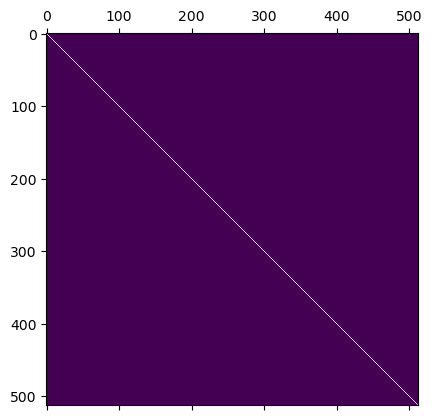

In [437]:
plt.matshow(K.image)

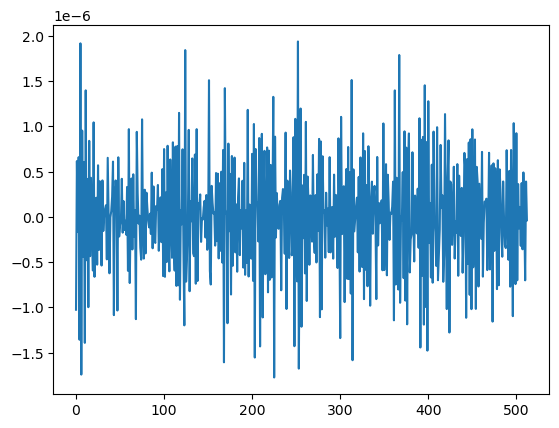

In [438]:
plt.plot(rjf_jacobian(K, x)[:,3])

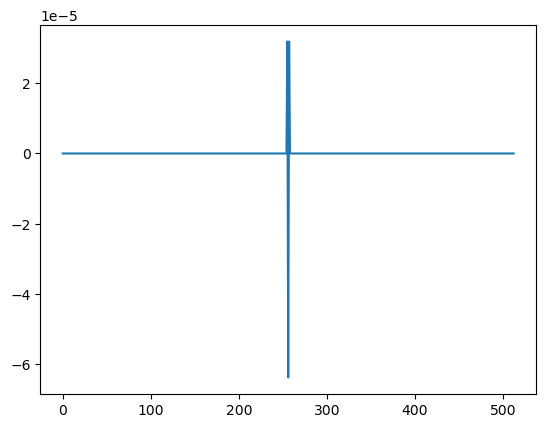

In [439]:
plt.plot(K.kernel.partial_derivatives[3])

In [440]:
A = np.block([[np.identity(4)], [5 * np.identity(4)]])

In [441]:
A @ A.T

array([[ 1.,  0.,  0.,  0.,  5.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  5.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  5.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  5.],
       [ 5.,  0.,  0.,  0., 25.,  0.,  0.,  0.],
       [ 0.,  5.,  0.,  0.,  0., 25.,  0.,  0.],
       [ 0.,  0.,  5.,  0.,  0.,  0., 25.,  0.],
       [ 0.,  0.,  0.,  5.,  0.,  0.,  0., 25.]])